# Final Project

By: Chengyi (Jeff) Chen

In [3]:
%load_ext autotime
%load_ext nb_black
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting Design Configs
sns.set(
    font="Verdana",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": True,
        "grid.color": "lightgrey",
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
        "figure.dpi": 100,
        "figure.figsize": (8, 6),
    },
)
sns.set_context(
    "notebook", rc={"font.size": 10, "axes.titlesize": 12, "axes.labelsize": 10}
)
sns.color_palette(palette="Spectral")

# General
import numpy as np
import scipy.stats as sp
import pandas as pd
from functools import partial

# Ignore warnings LOL
import warnings

warnings.simplefilter("ignore")

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
time: 6.84 s


<IPython.core.display.Javascript object>

In [4]:
def ρ(γ):
    """Risk tolerance"""
    return 1 / γ

time: 281 µs


<IPython.core.display.Javascript object>

In [5]:
def r(γ):
    """Risk Odds"""
    return np.log(γ)

time: 276 µs


<IPython.core.display.Javascript object>

In [6]:
def u(x, γ: np.array = np.array([0.0]), a: float = 0.0, b: float = 1.0):
    """Assuming user satisifies the Δ property,
    calculates the U-values using either a
    Piecewise Linear u = a + bx if γ = 0 (Risk-Neutral)
    else Exponential u = a + be^(-xγ) U-curve U(x)

    Args:
        x (np.array): Payoffs of prospects matrix, Shape = (Number of deals, Number of prospects in each deal)
        γ (np.array): Risk-aversion coefficients, Shape = (Number of different risk-aversion coefficients for sensitivity analysis), Default = 0.0 (Risk-neutral) [γ > 0: Risk-averse, γ < 0: Risk-seeking]
        a (float): Constant for U-curve
        b (float): Coefficient for payoff variable

    Returns:
        np.array:
            U-values, Shape = (Number of Risk Aversion Coefficients γ, Number of deals, Number of prospects in each deal)
    """
    assert (
        x.ndim == 2
    ), "Payoffs require 2 dimensions, first dim is number of deals, second is number of prospects in each deal."
    γ = np.array([γ]) if np.isscalar(γ) else np.array(γ)
    return np.array(
        [
            np.apply_along_axis(
                func1d=lambda x, γ=γ: a + b * x if γ == 0 else a + b * np.exp(-x * γ),
                axis=-1,
                arr=x,
                γ=γ_i,
            )
            for γ_i in γ
        ]
    )

time: 627 µs


<IPython.core.display.Javascript object>

In [7]:
def eu(u, p):
    """Assuming user satisifies the Δ property, calculates the
    hadamard product of the u values matrix and probabilities
    matrix (respective probabilities associated with each
    prospect in the u matrix)

    Args:
        u (np.array): U-values matrix, Shape = (Number of Risk Aversion Coefficients γ, Number of deals, Number of prospects in each deal)
        p (np.array): Probabilities of each prospect matrix, Shape = (Number of Risk Aversion Coefficients γ, Number of deals, Number of prospects in each deal)

    Returns:
        np.array:
            E-values, Shape = (Number of Risk Aversion Coefficients γ, Number of deals)
    """
    assert (
        u.shape == p.shape
    ), "U-values matrix must be the same shape as the probabilities matrix."

    assert (
        u.ndim == 3
    ), "Both matrices must have 3 dimensions, Shape = (Number of Risk Aversion Coefficients γ, Number of deals, Number of prospects in each deal)."

    return np.sum(u * p, axis=-1)

time: 405 µs


<IPython.core.display.Javascript object>

In [8]:
def u_inv(eu, γ: np.array = np.array([0.0]), a: float = 0, b: float = 1):
    """Piecewise Inverse of Linear if γ = 0 (Risk-Neutral)
    else Inverse of Exponential U-curve Certain equivalent
    function U^{-1}(x)

    Args:
        eu (np.array): E[U-Values] / Expectation over u-values, AKA E-values, Shape = (Number of Risk Aversion Coefficients γ, Number of deals)
        γ (np.array): Risk-aversion coefficients, Shape = (Number of different risk-aversion coefficients for sensitivity analysis), Default = 0.0 (Risk-neutral) [γ > 0: Risk-averse, γ < 0: Risk-seeking]
        a (float): Constant for U-curve
        b (float): Coefficient for payoff variable

    Returns:
        np.array:
             Certainty Equivalent values, Shape = (Number of Risk Aversion Coefficients γ, Number of deals)
    """
    γ = np.array([γ]) if np.isscalar(γ) else np.array(γ)

    for eu_i, γ_i in zip(eu, γ):
        if not np.isclose(γ_i, 0):
            assert np.alltrue(
                eu_i > 0
            ), "E[U-Values] / Expectation over u-values must be positive for γ > 0 and γ < 0 in order for inverse of Exponential U-curve to work."

    assert (
        eu.shape[0] == γ.shape[0]
    ), "E-values first dimension must be the same as γ first dimension for inverse operation."

    return np.array(
        [
            list(
                map(
                    lambda eu, γ=γ_i: (eu - a) / b if γ == 0 else -(1 / γ) * np.log(eu),
                    eu_i,
                )
            )
            for eu_i, γ_i in zip(eu, γ)
        ]
    )

time: 762 µs


<IPython.core.display.Javascript object>

In [9]:
def certainty_equivalent_values_calculator(
    u,
    u_inv,
    x: np.array = None,
    p: np.array = None,
    N: int = 10,
    payout_lb: float = 0.0,
    payout_ub: float = 100.0,
    γ: np.array = np.array([0.0]),
):
    """Assuming user satisifies the Δ property, calculates the Certainty Equivalent values for a given
    payoff matrix `x` and probability matrix `p`. If both matrices
    are not provided, random matrices will be sampled to simulate
    calculations.

    Args:
        u (function): U-curve function
        u_inv (function): Inverse U-curve function
        x (np.array): Payoffs of prospects matrix, Shape = (Number of deals, Number of prospects in each deal)
        p (np.array): Probabilities of each prospect matrix, Shape = (Number of deals, Number of prospects in each deal)
        N (int): Number of prospects
        payout_lb (float): Lower Bound of Payout for simulation, Default = 0.0
        payout_ub (float): Upper Bound of Payout for simulation, Default = 100.0
        γ (np.array): Risk-aversion coefficients, Shape = (Number of different risk-aversion coefficients for sensitivity analysis), Default = 0.0 (Risk-neutral) [γ > 0: Risk-averse, γ < 0: Risk-seeking]

    Returns:
        np.array:
            Certainty Equivalent values, Shape = (Number of Risk Aversion Coefficients γ, Number of deals)
    """
    γ = np.array([γ]) if np.isscalar(γ) else np.array(γ)

    # Case 1: Simulator - Both x and p arent provided
    if p is None and x is None:

        # Preferential probabilities for each prospect
        p = np.random.dirichlet(np.ones(N), size=1)

        # Payouts for each prospect
        x = np.expand_dims(np.random.randint(payout_lb, payout_ub, size=N), axis=0)

    # Case 2: Simulator - Only payouts provided
    elif p is None:

        # Payouts for each prospect
        x = np.expand_dims(
            np.random.randint(payout_lb, payout_ub, size=p.shape[-1]), axis=0
        )

    # Case 3: Simulator - Only probabilities provided
    elif x is None:

        # Preferential probabilities for each prospect
        p = np.random.dirichlet(np.ones(x.shape[-1]), size=1)

    # Case 4: Calculator - Both are provided
    else:

        pass

    # Check that payoffs and probability assignments are the same shape
    assert (
        x.shape == p.shape
    ), "Payoffs `x` and Probabilities `p` must be the same shape=(Number of deals, Number of prospects in each deal)."

    # Calculates U-values Shape = (Number of Risk Aversion Coefficients γ, Number of deals, Number of prospects in each deal)
    u_values = u(x, γ=γ)

    # Reshape p to match U-values shape
    p_reshaped = np.array([p for _ in range(u_values.shape[0])])

    # Expectation of U values Shape = (Number of Risk Aversion Coefficients γ, Number of deals)
    eu_values = eu(u=u_values, p=p_reshaped)

    # Certainty equivalent value of deal
    ce_values = u_inv(eu_values, γ=γ)

    return ce_values

time: 951 µs


<IPython.core.display.Javascript object>

---
## 1) Tornado Diagrams for Strategies

In [61]:
def tornado_diagram(npv, name):

    # Max Swing
    max_swing = npv.max(axis=1) - npv.min(axis=1)

    # Max Swing Squared
    max_swing_squared = max_swing ** 2

    # Normalized Max Swing Squared
    norm_max_swing_squared = max_swing_squared / sum(max_swing_squared)

    # Tornado diagram
    npv = npv.reindex(norm_max_swing_squared.sort_values().index)

    fig, ax = plt.subplots()

    ax.barh(
        npv.index,
        npv["50%"].values - npv["10%"].values,
        0.35,
        align="center",
        label="10%",
        left=npv["10%"].values,
    )
    ax.barh(
        npv.index,
        npv["90%"].values - npv["50%"].values,
        0.35,
        align="center",
        label="90%",
        left=npv["50%"].values,
    )

    ax.set_ylabel("Uncertainties")
    ax.set_title(name)
    ax.legend()

    plt.show()

    return pd.concat(
        [
            npv,
            pd.concat(
                [
                    max_swing,
                    max_swing_squared,
                    norm_max_swing_squared,
                ],
                keys=["D", "D^2", "D^2 / sum"],
                axis=1,
            ),
        ],
        axis=1,
    )

time: 845 µs


<IPython.core.display.Javascript object>

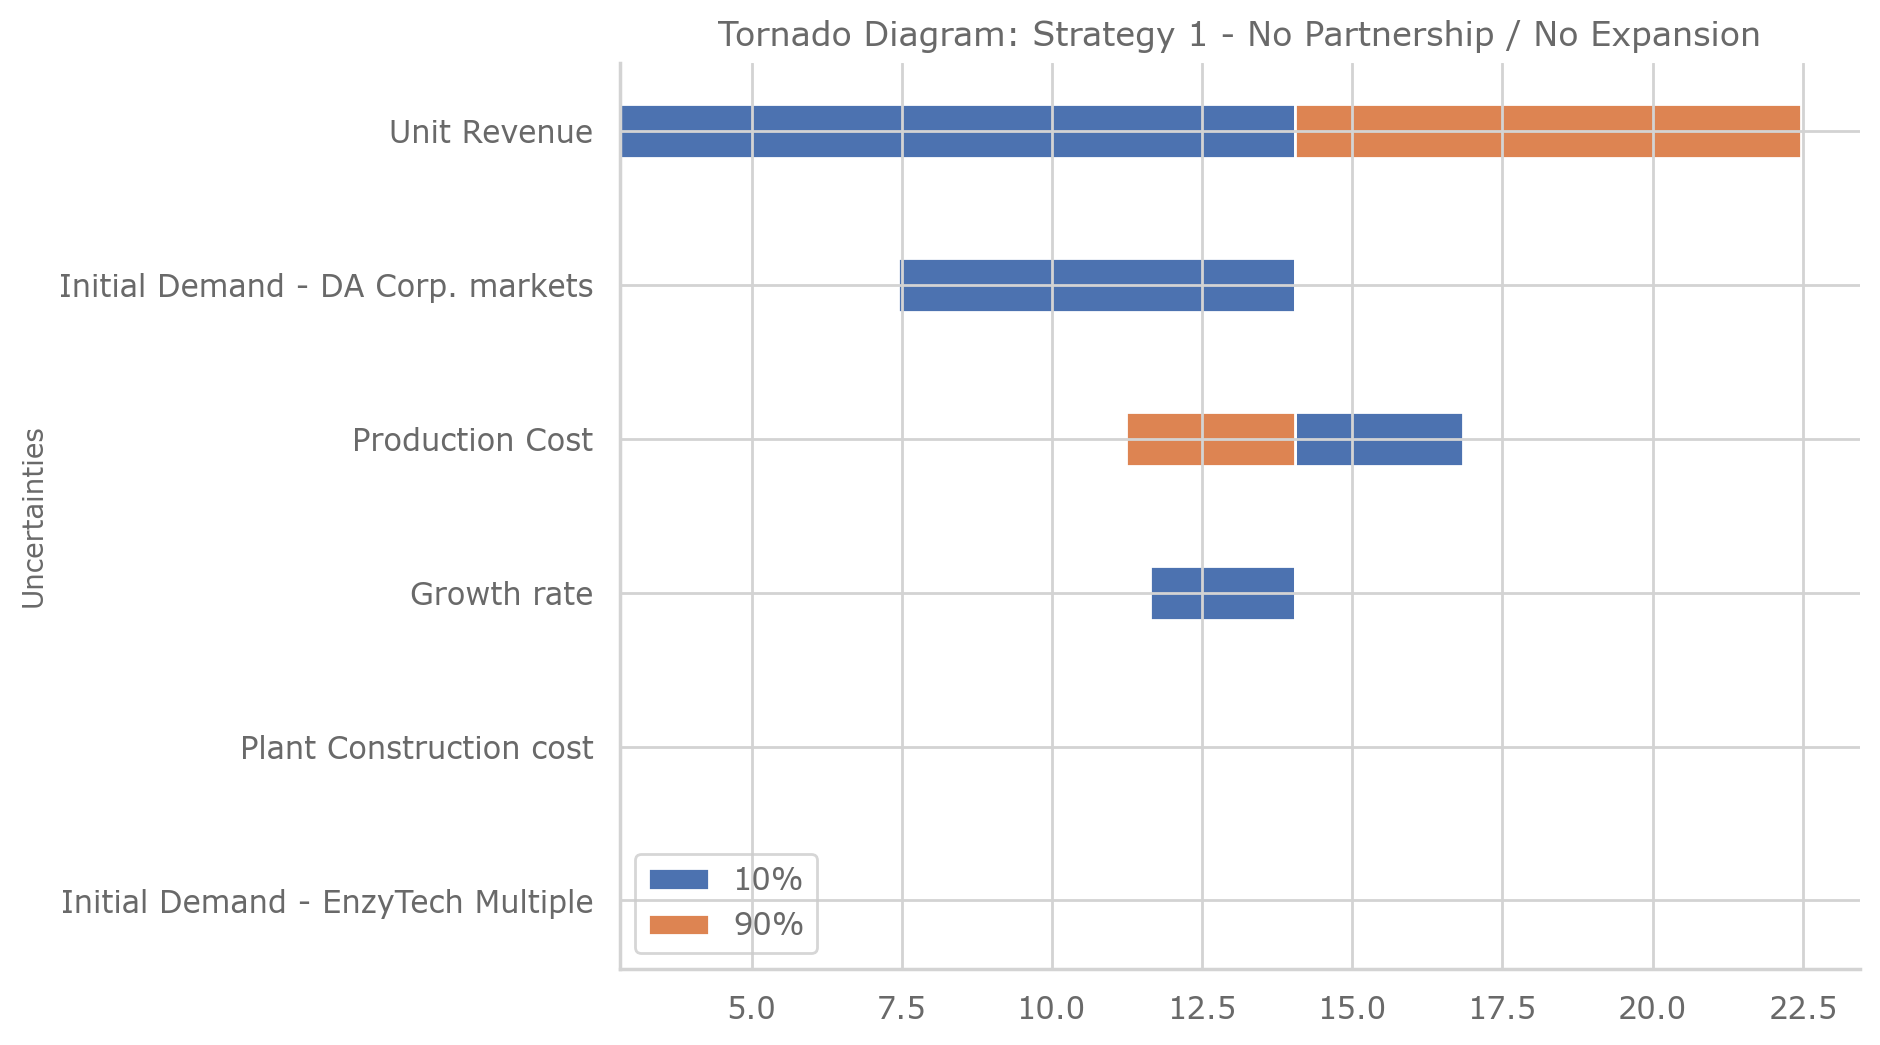

,10%,50%,90%,D,D^2,D^2 / sum
Initial Demand - EnzyTech Multiple,14.04,14.04,14.04,0.00,0.0000,0.000000
Plant Construction cost,14.04,14.04,14.04,0.00,0.0000,0.000000
Growth rate,11.63,14.04,14.04,2.41,5.8081,0.012421
Production Cost,16.85,14.04,11.23,5.62,31.5844,0.067546
Initial Demand - DA Corp. markets,7.43,14.04,14.04,6.61,43.6921,0.093439
Unit Revenue,2.81,14.04,22.47,19.66,386.5156,0.826594


time: 377 ms


<IPython.core.display.Javascript object>

In [62]:
# Strategy 1: No Partnership / No Expansion

strategy1_npv = pd.DataFrame(
    data=[
        [7.43, 14.04, 14.04],
        [11.63, 14.04, 14.04],
        [14.04, 14.04, 14.04],
        [2.81, 14.04, 22.47],
        [16.85, 14.04, 11.23],
        [14.04, 14.04, 14.04],
    ],
    index=[
        "Initial Demand - DA Corp. markets",
        "Growth rate",
        "Initial Demand - EnzyTech Multiple",
        "Unit Revenue",
        "Production Cost",
        "Plant Construction cost",
    ],
    columns=["10%", "50%", "90%"],
)

tornado_diagram(
    strategy1_npv, name="Tornado Diagram: Strategy 1 - No Partnership / No Expansion"
)

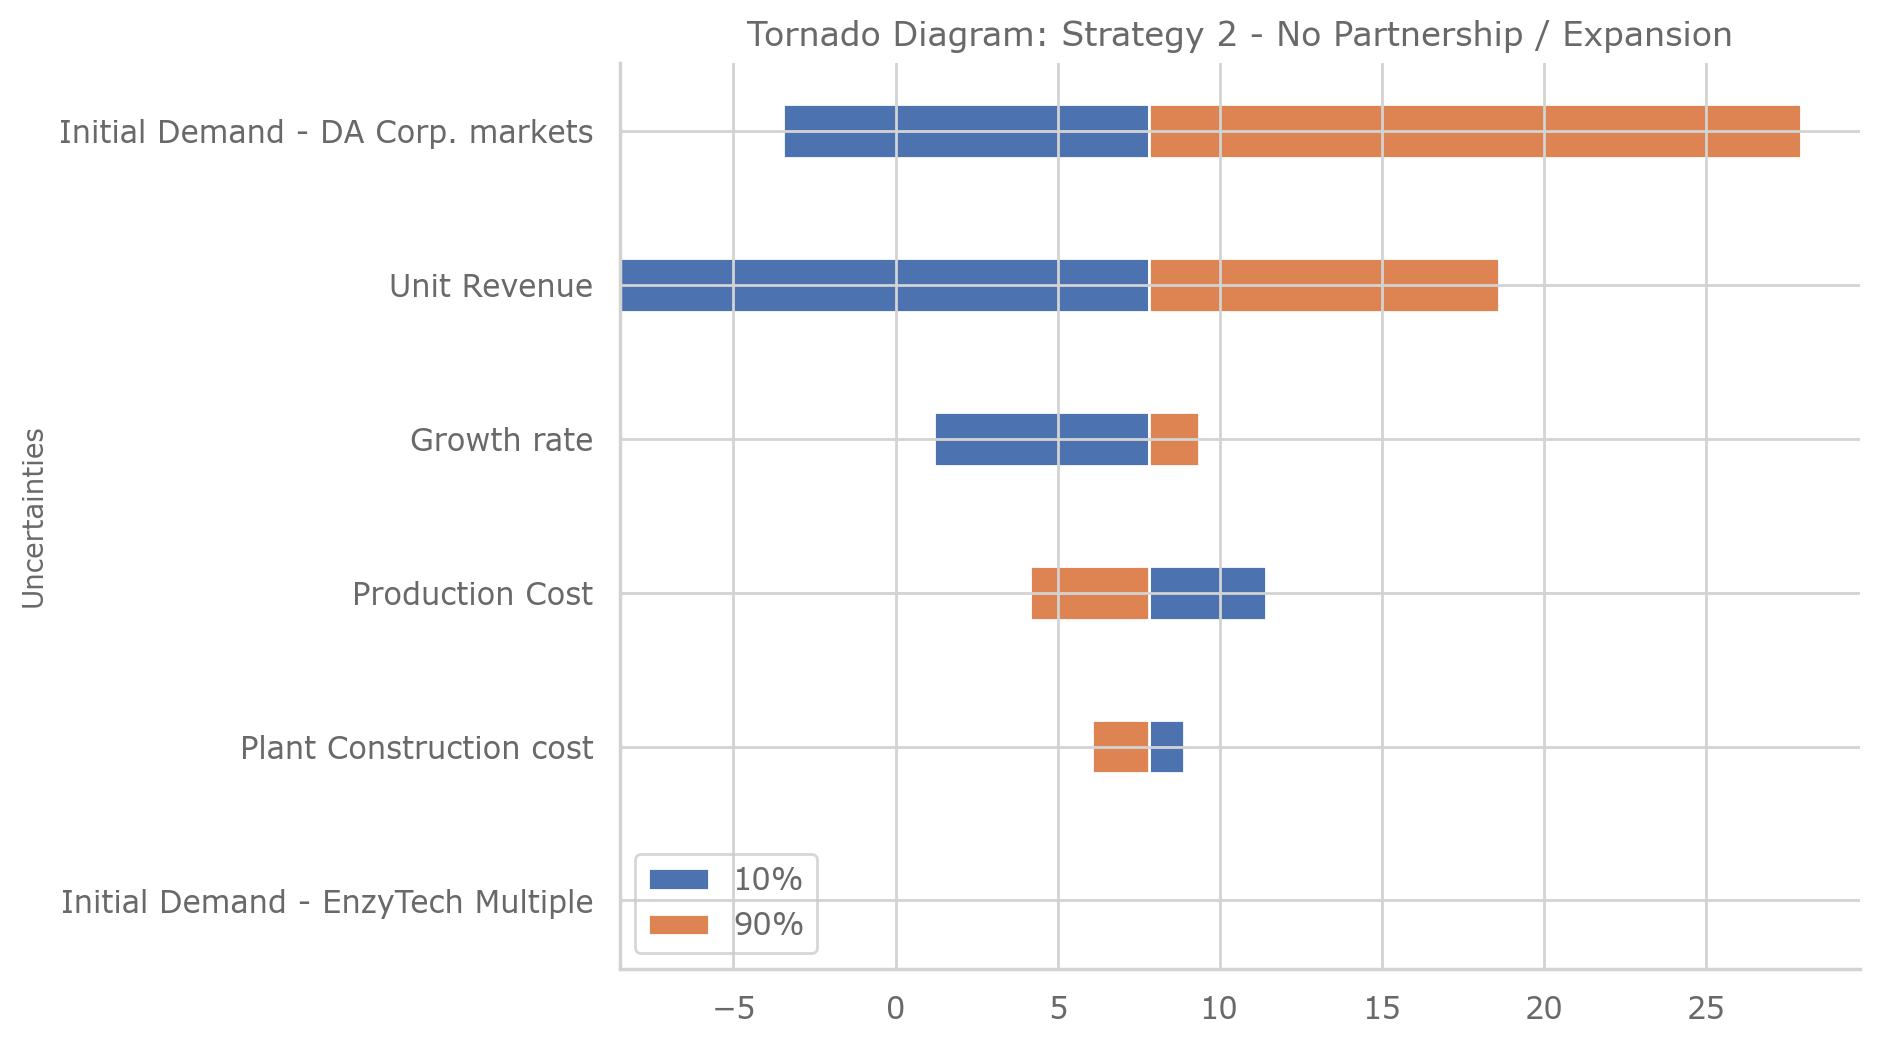

,10%,50%,90%,D,D^2,D^2 / sum
Initial Demand - EnzyTech Multiple,7.81,7.81,7.81,0.00,0.0000,0.000000
Plant Construction cost,8.91,7.81,6.06,2.85,8.1225,0.004396
Production Cost,11.44,7.81,4.15,7.29,53.1441,0.028761
Growth rate,1.19,7.81,9.36,8.17,66.7489,0.036124
Unit Revenue,-8.50,7.81,18.60,27.10,734.4100,0.397460
Initial Demand - DA Corp. markets,-3.46,7.81,27.93,31.39,985.3321,0.533258


time: 363 ms


<IPython.core.display.Javascript object>

In [63]:
# Strategy 2: No Partnership / Expansion

strategy2_npv = pd.DataFrame(
    data=[
        [-3.46, 7.81, 27.93],
        [1.19, 7.81, 9.36],
        [7.81, 7.81, 7.81],
        [-8.5, 7.81, 18.6],
        [11.44, 7.81, 4.15],
        [8.91, 7.81, 6.06],
    ],
    index=[
        "Initial Demand - DA Corp. markets",
        "Growth rate",
        "Initial Demand - EnzyTech Multiple",
        "Unit Revenue",
        "Production Cost",
        "Plant Construction cost",
    ],
    columns=["10%", "50%", "90%"],
)

tornado_diagram(
    strategy2_npv, name="Tornado Diagram: Strategy 2 - No Partnership / Expansion"
)

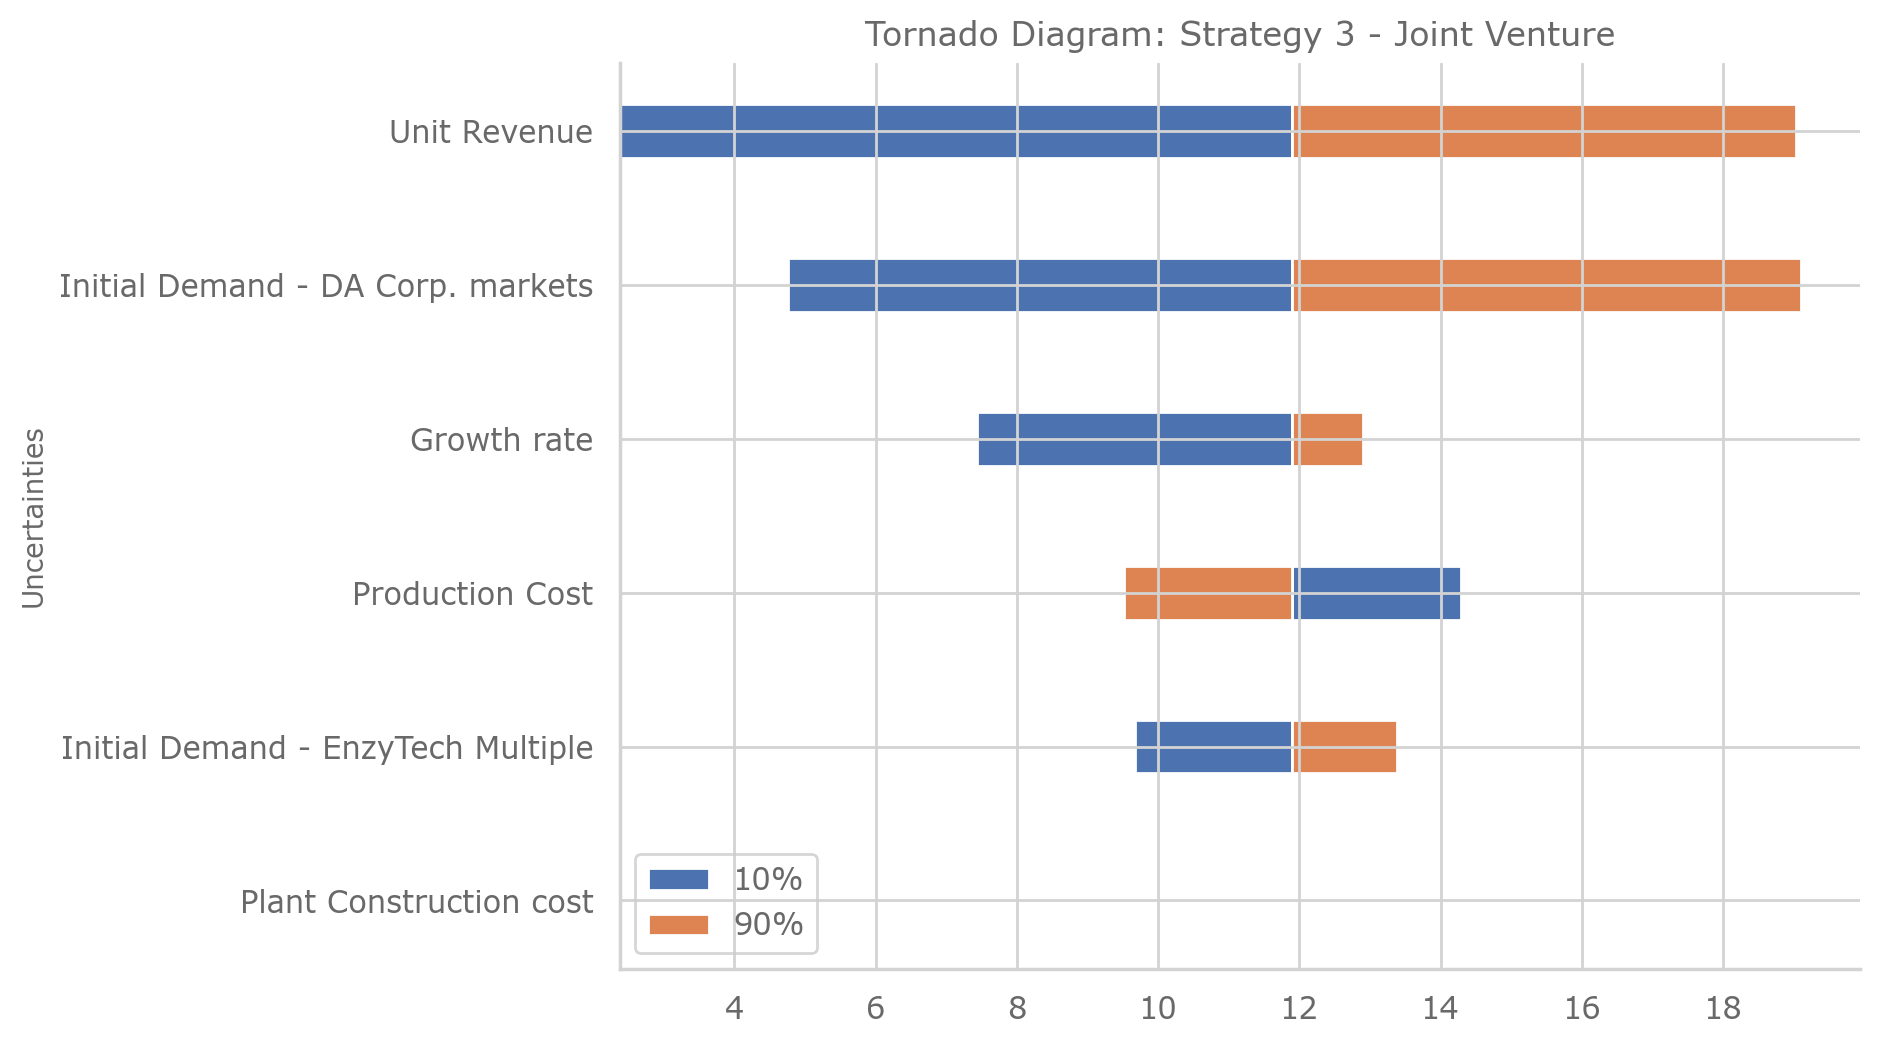

,10%,50%,90%,D,D^2,D^2 / sum
Plant Construction cost,11.90,11.9,11.90,0.00,0.0000,0.000000
Initial Demand - EnzyTech Multiple,9.67,11.9,13.38,3.71,13.7641,0.025067
Production Cost,14.28,11.9,9.52,4.76,22.6576,0.041264
Growth rate,7.44,11.9,12.90,5.46,29.8116,0.054293
Initial Demand - DA Corp. markets,4.76,11.9,19.10,14.34,205.6356,0.374502
Unit Revenue,2.38,11.9,19.03,16.65,277.2225,0.504875


time: 363 ms


<IPython.core.display.Javascript object>

In [64]:
# Strategy 3: Joint Venture

strategy3_npv = pd.DataFrame(
    data=[
        [4.76, 11.9, 19.1],
        [7.44, 11.9, 12.9],
        [9.67, 11.9, 13.38],
        [2.38, 11.9, 19.03],
        [14.28, 11.9, 9.52],
        [11.9, 11.9, 11.9],
    ],
    index=[
        "Initial Demand - DA Corp. markets",
        "Growth rate",
        "Initial Demand - EnzyTech Multiple",
        "Unit Revenue",
        "Production Cost",
        "Plant Construction cost",
    ],
    columns=["10%", "50%", "90%"],
)

tornado_diagram(strategy3_npv, name="Tornado Diagram: Strategy 3 - Joint Venture")

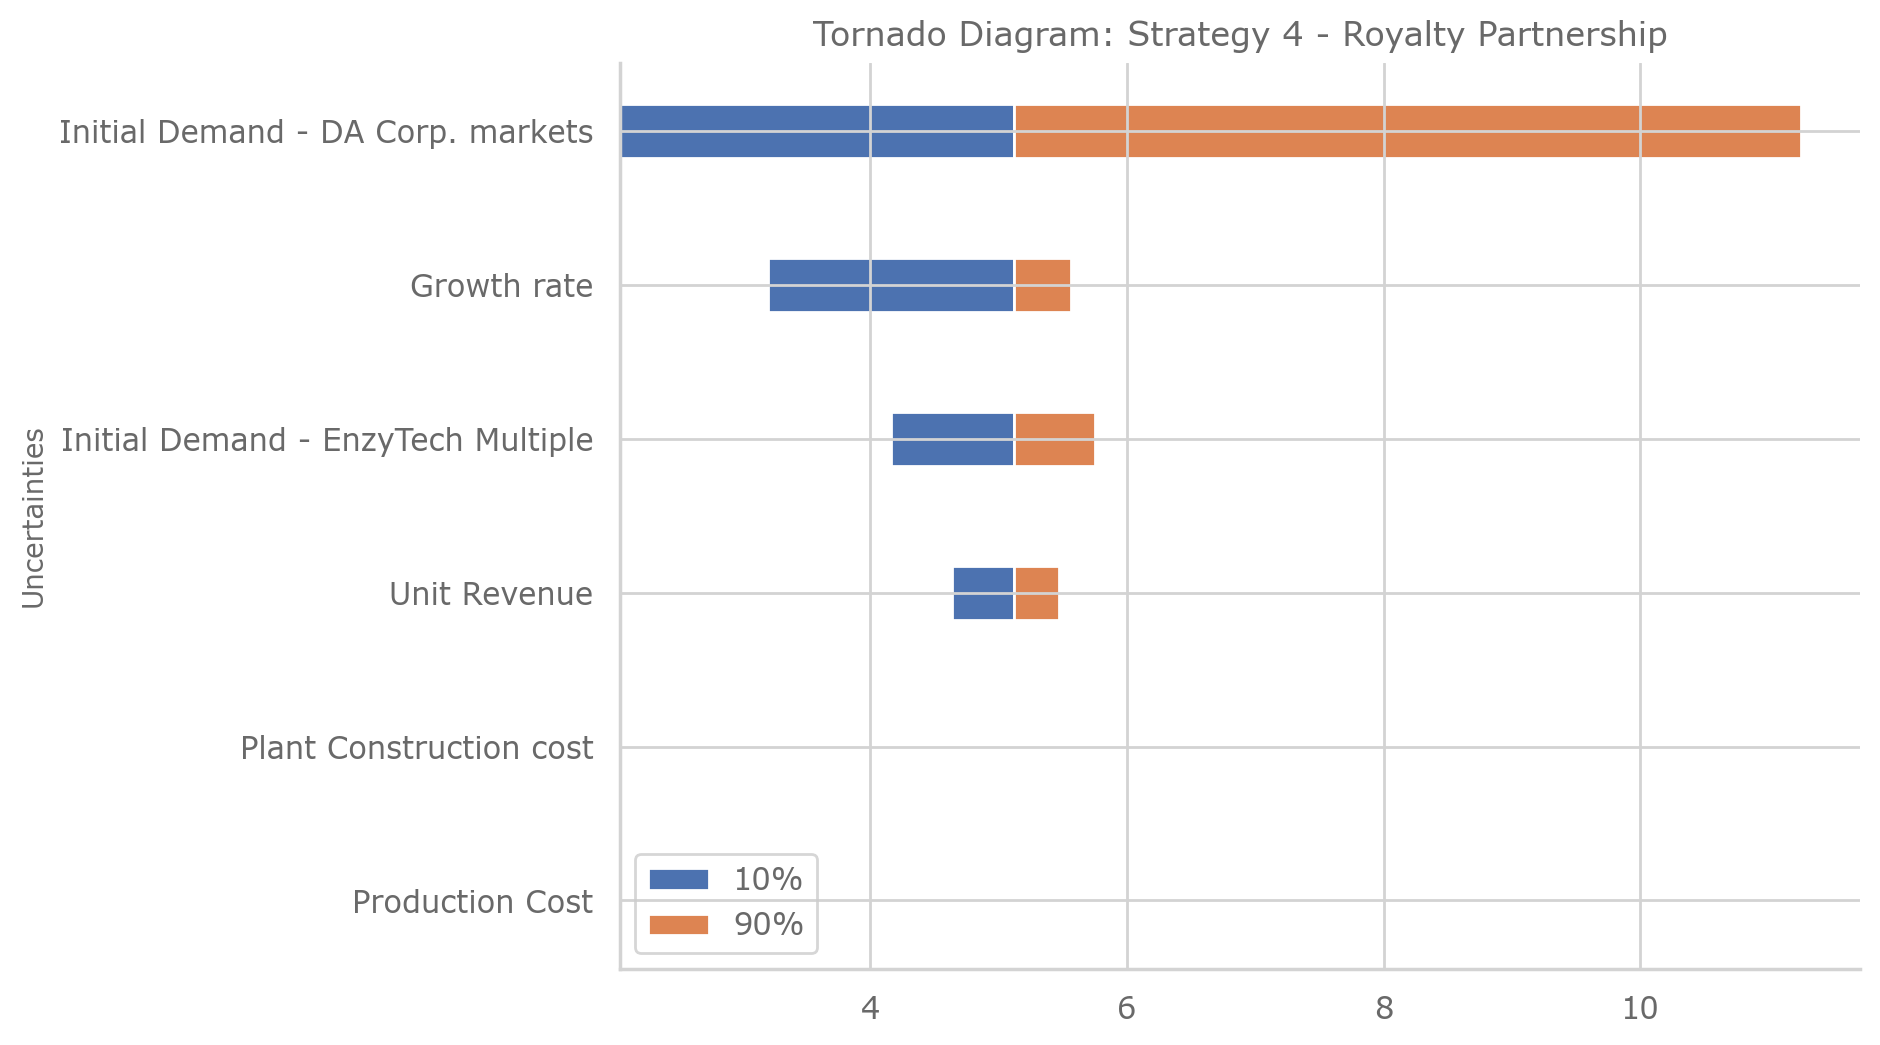

,10%,50%,90%,D,D^2,D^2 / sum
Production Cost,5.12,5.12,5.12,0.00,0.0000,0.000000
Plant Construction cost,5.12,5.12,5.12,0.00,0.0000,0.000000
Unit Revenue,4.64,5.12,5.47,0.83,0.6889,0.007374
Initial Demand - EnzyTech Multiple,4.16,5.12,5.75,1.59,2.5281,0.027060
Growth rate,3.20,5.12,5.56,2.36,5.5696,0.059615
Initial Demand - DA Corp. markets,2.05,5.12,11.25,9.20,84.6400,0.905952


time: 500 ms


<IPython.core.display.Javascript object>

In [125]:
# Strategy 4: Royalty Partnership

strategy4_npv = pd.DataFrame(
    data=[
        [2.05, 5.12, 11.25],
        [3.20, 5.12, 5.56],
        [4.16, 5.12, 5.75],
        [4.64, 5.12, 5.47],
        [5.12, 5.12, 5.12],
        [5.12, 5.12, 5.12],
    ],
    index=[
        "Initial Demand - DA Corp. markets",
        "Growth rate",
        "Initial Demand - EnzyTech Multiple",
        "Unit Revenue",
        "Production Cost",
        "Plant Construction cost",
    ],
    columns=["10%", "50%", "90%"],
)

tornado_diagram(strategy4_npv, name="Tornado Diagram: Strategy 4 - Royalty Partnership")

---
## 2) Sensitivity Analysis

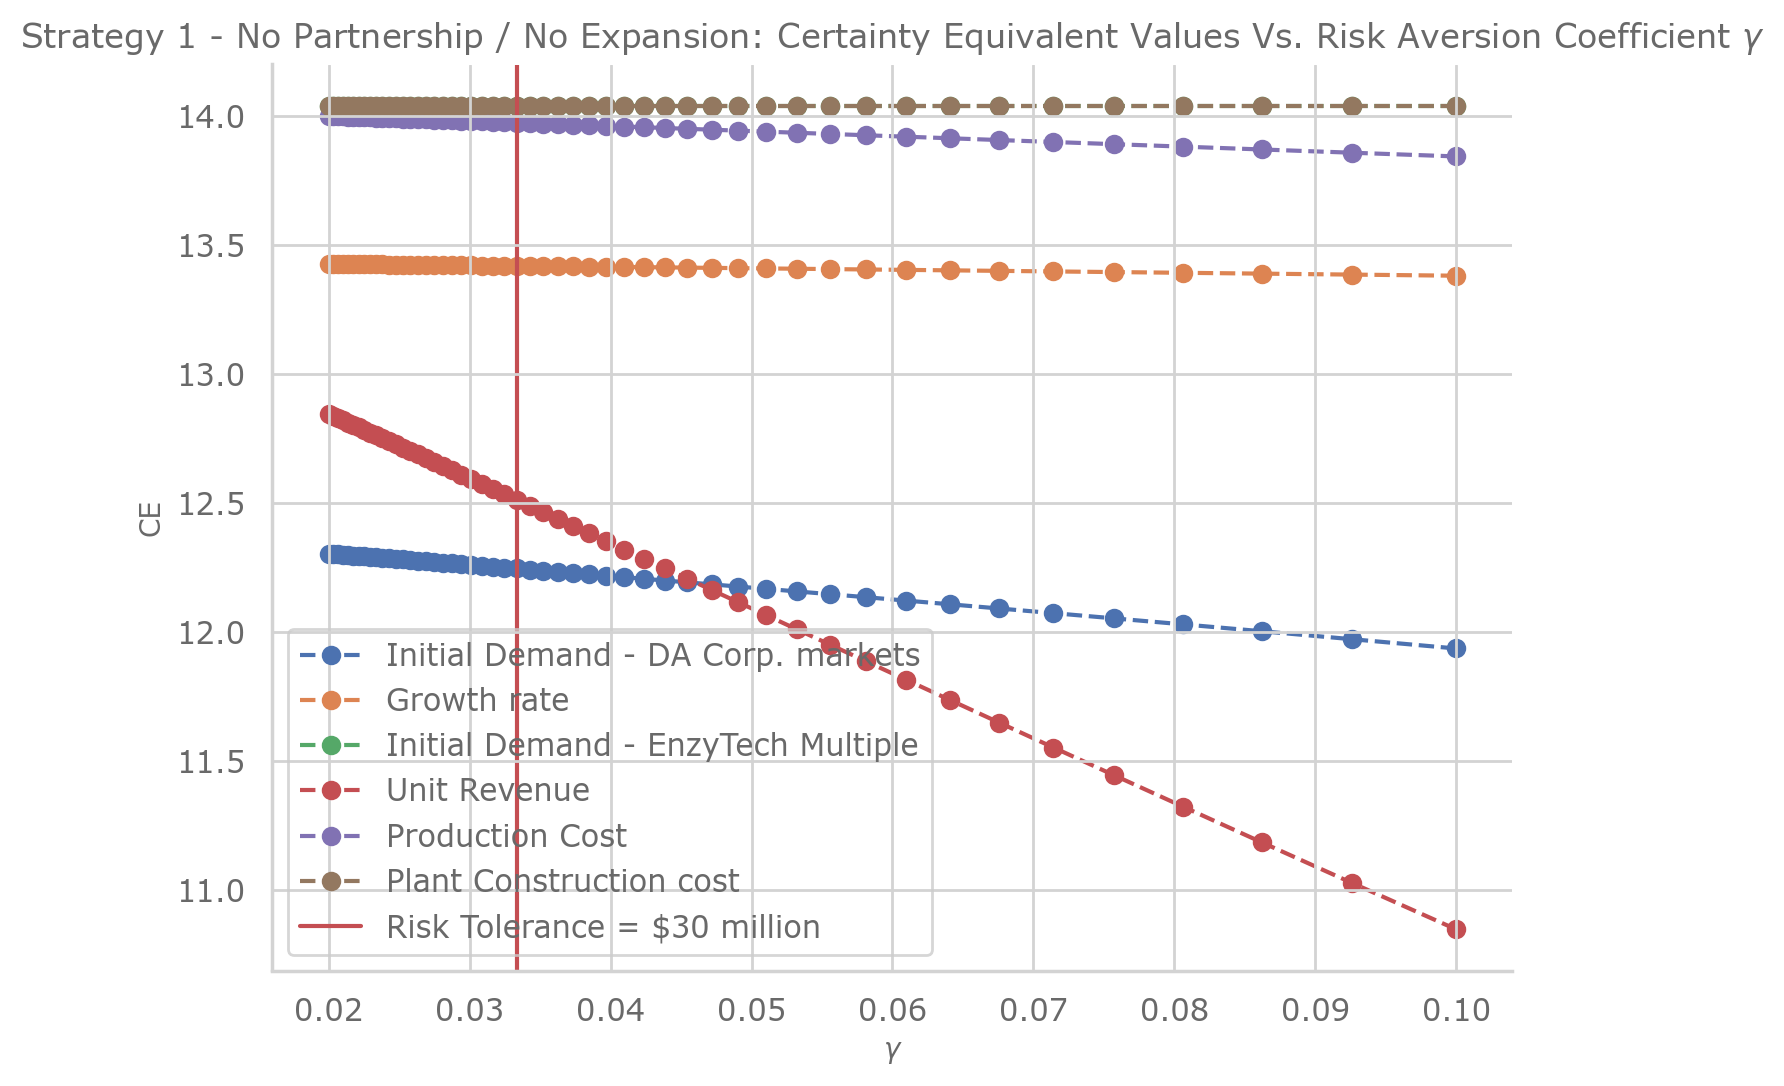

time: 435 ms


<IPython.core.display.Javascript object>

In [95]:
def certainty_equivalent_sensitivity_to_risk_tolerance_analysis(npv, name):
    """DA Corp. follows the delta-property and has a risk tolerance of $30 million."""
    fig, ax = plt.subplots(1, 1)

    γ = np.array([1 / risk_tolerance for risk_tolerance in np.linspace(10, 50, 51)])

    for uncertainty, ce_values in zip(
        npv.index,
        certainty_equivalent_values_calculator(
            u,
            u_inv,
            x=npv.to_numpy(),
            p=np.array([[0.25, 0.5, 0.25]] * npv.shape[0]),
            N=None,
            payout_lb=None,
            payout_ub=None,
            γ=γ,
        ).T,
    ):
        ax.plot(γ, ce_values, linestyle="--", marker="o", label=uncertainty)

    ax.set_xlabel(r"$\gamma$")
    ax.set_ylabel("CE")
    ax.set_title(name)
    plt.axvline(x=1 / 30, label="Risk Tolerance = \$30 million", c="r")
    plt.legend()
    plt.show()


certainty_equivalent_sensitivity_to_risk_tolerance_analysis(
    strategy1_npv,
    name=r"Strategy 1 - No Partnership / No Expansion: Certainty Equivalent Values Vs. Risk Aversion Coefficient $\gamma$",
)

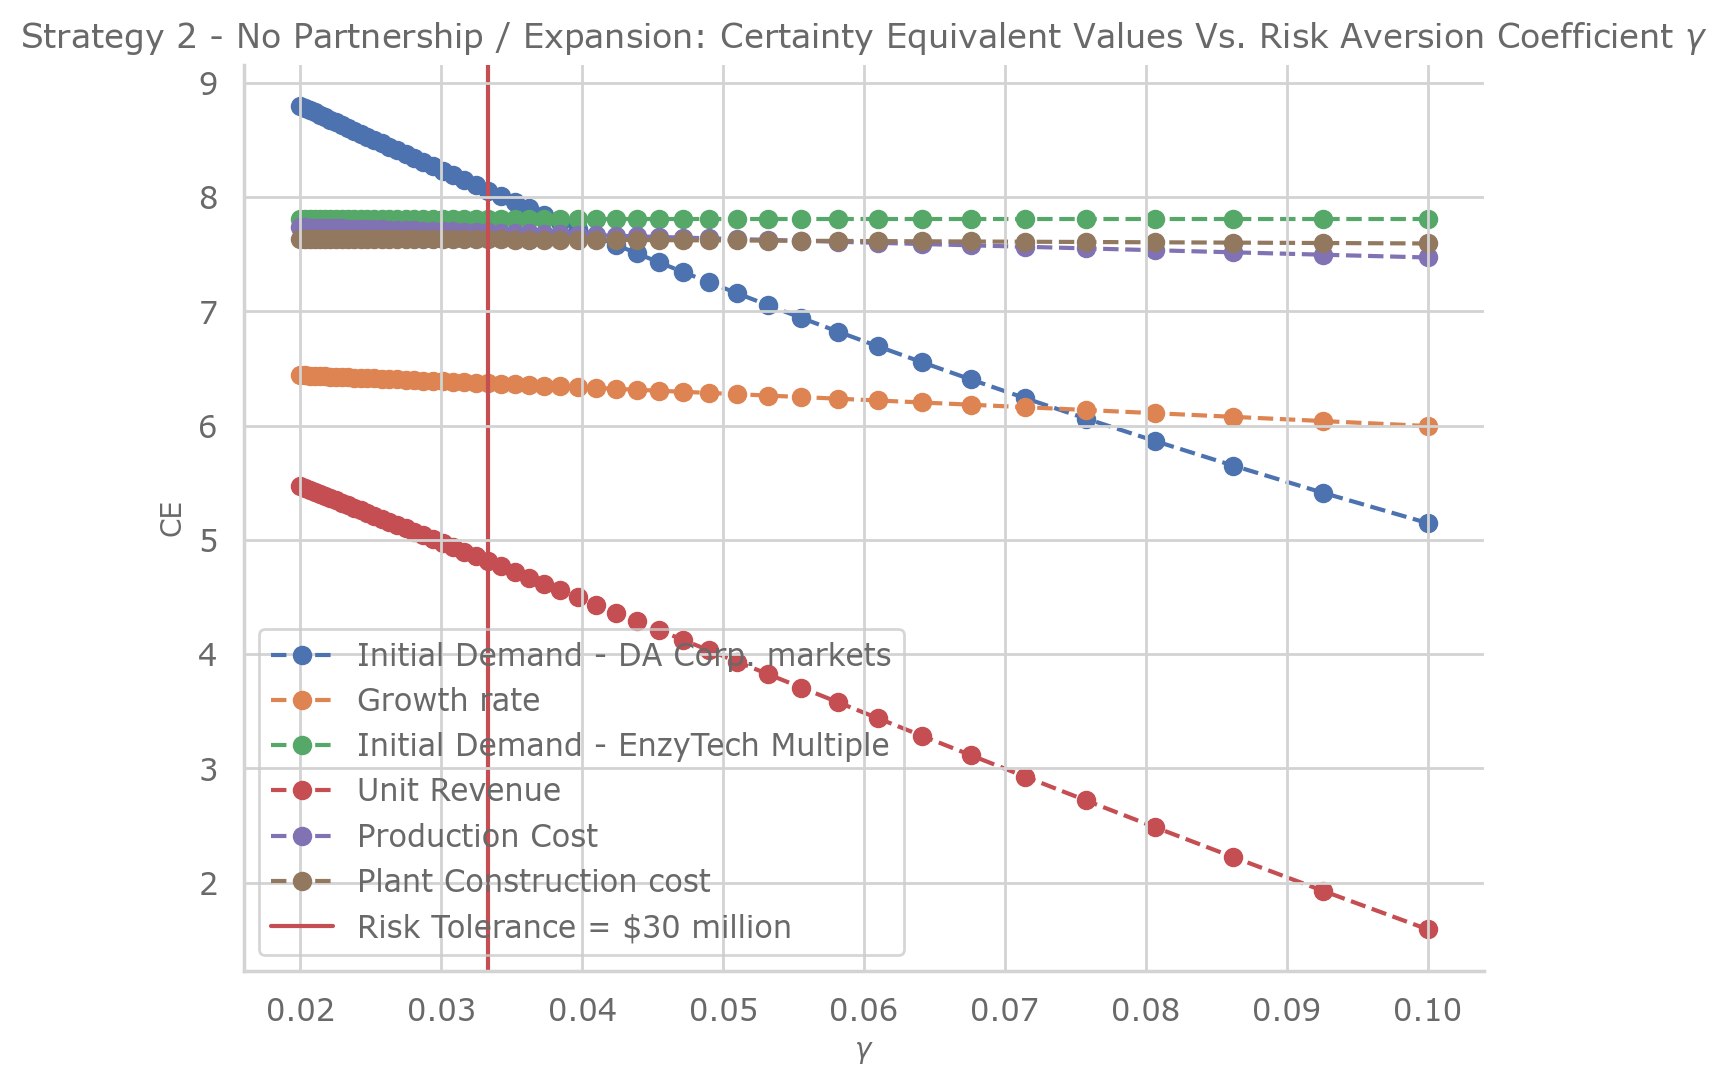

time: 574 ms


<IPython.core.display.Javascript object>

In [96]:
certainty_equivalent_sensitivity_to_risk_tolerance_analysis(
    strategy2_npv,
    name=r"Strategy 2 - No Partnership / Expansion: Certainty Equivalent Values Vs. Risk Aversion Coefficient $\gamma$",
)

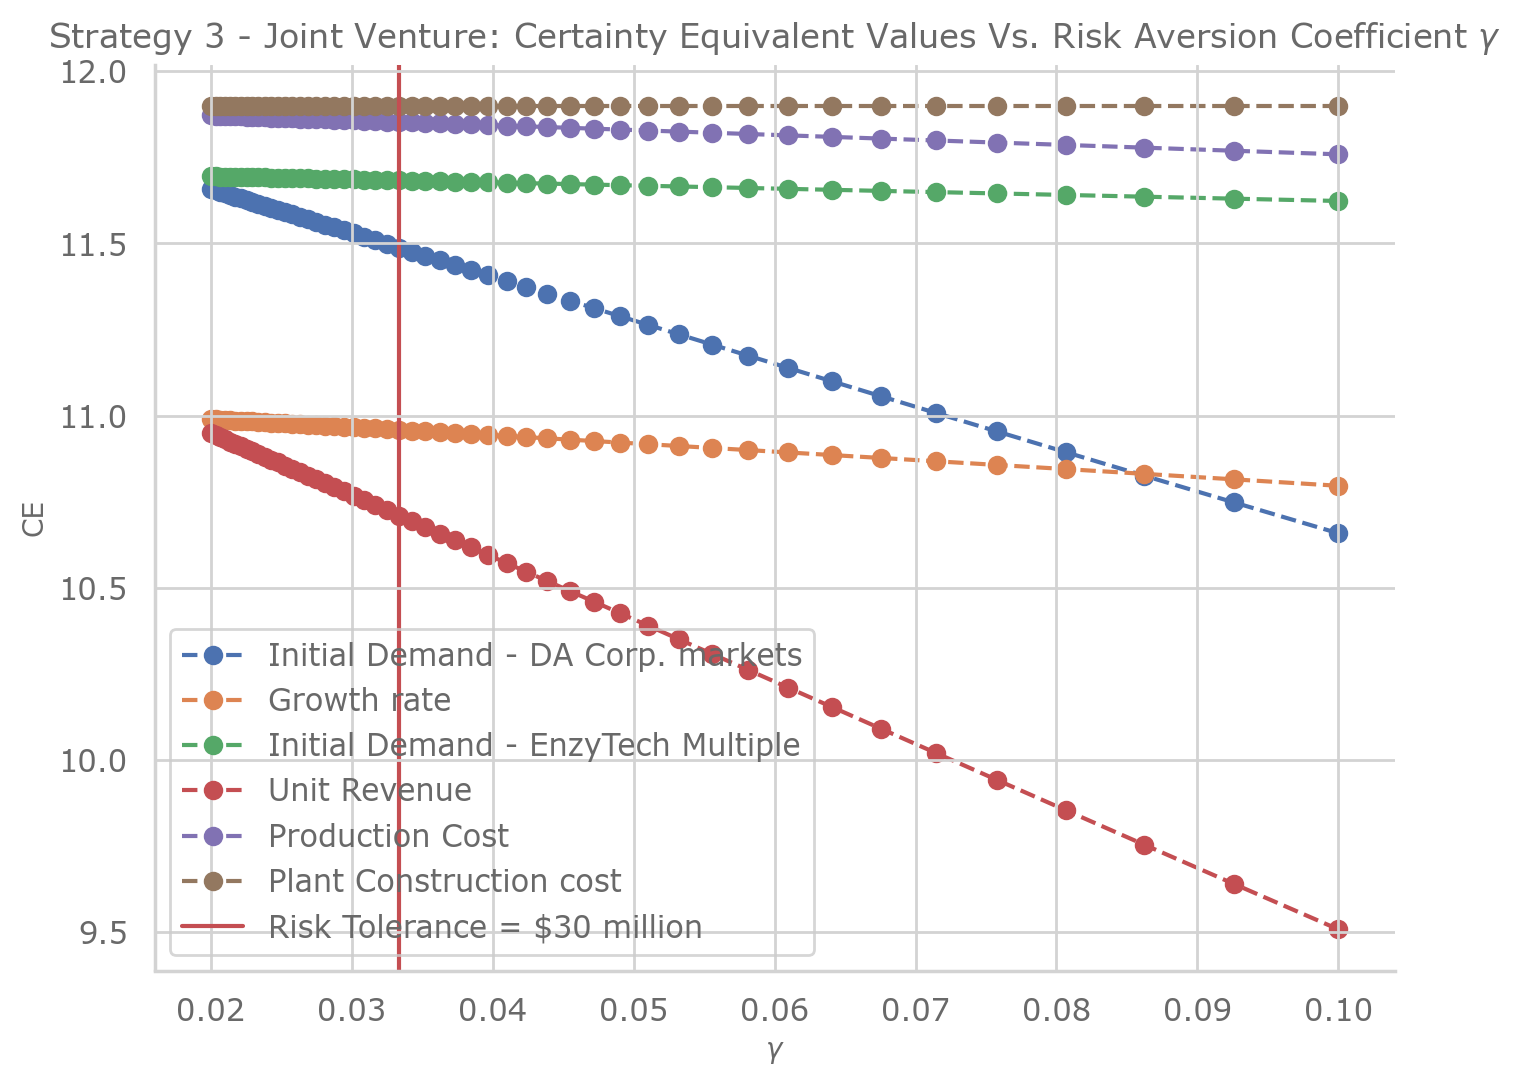

time: 442 ms


<IPython.core.display.Javascript object>

In [97]:
certainty_equivalent_sensitivity_to_risk_tolerance_analysis(
    strategy3_npv,
    name=r"Strategy 3 - Joint Venture: Certainty Equivalent Values Vs. Risk Aversion Coefficient $\gamma$",
)

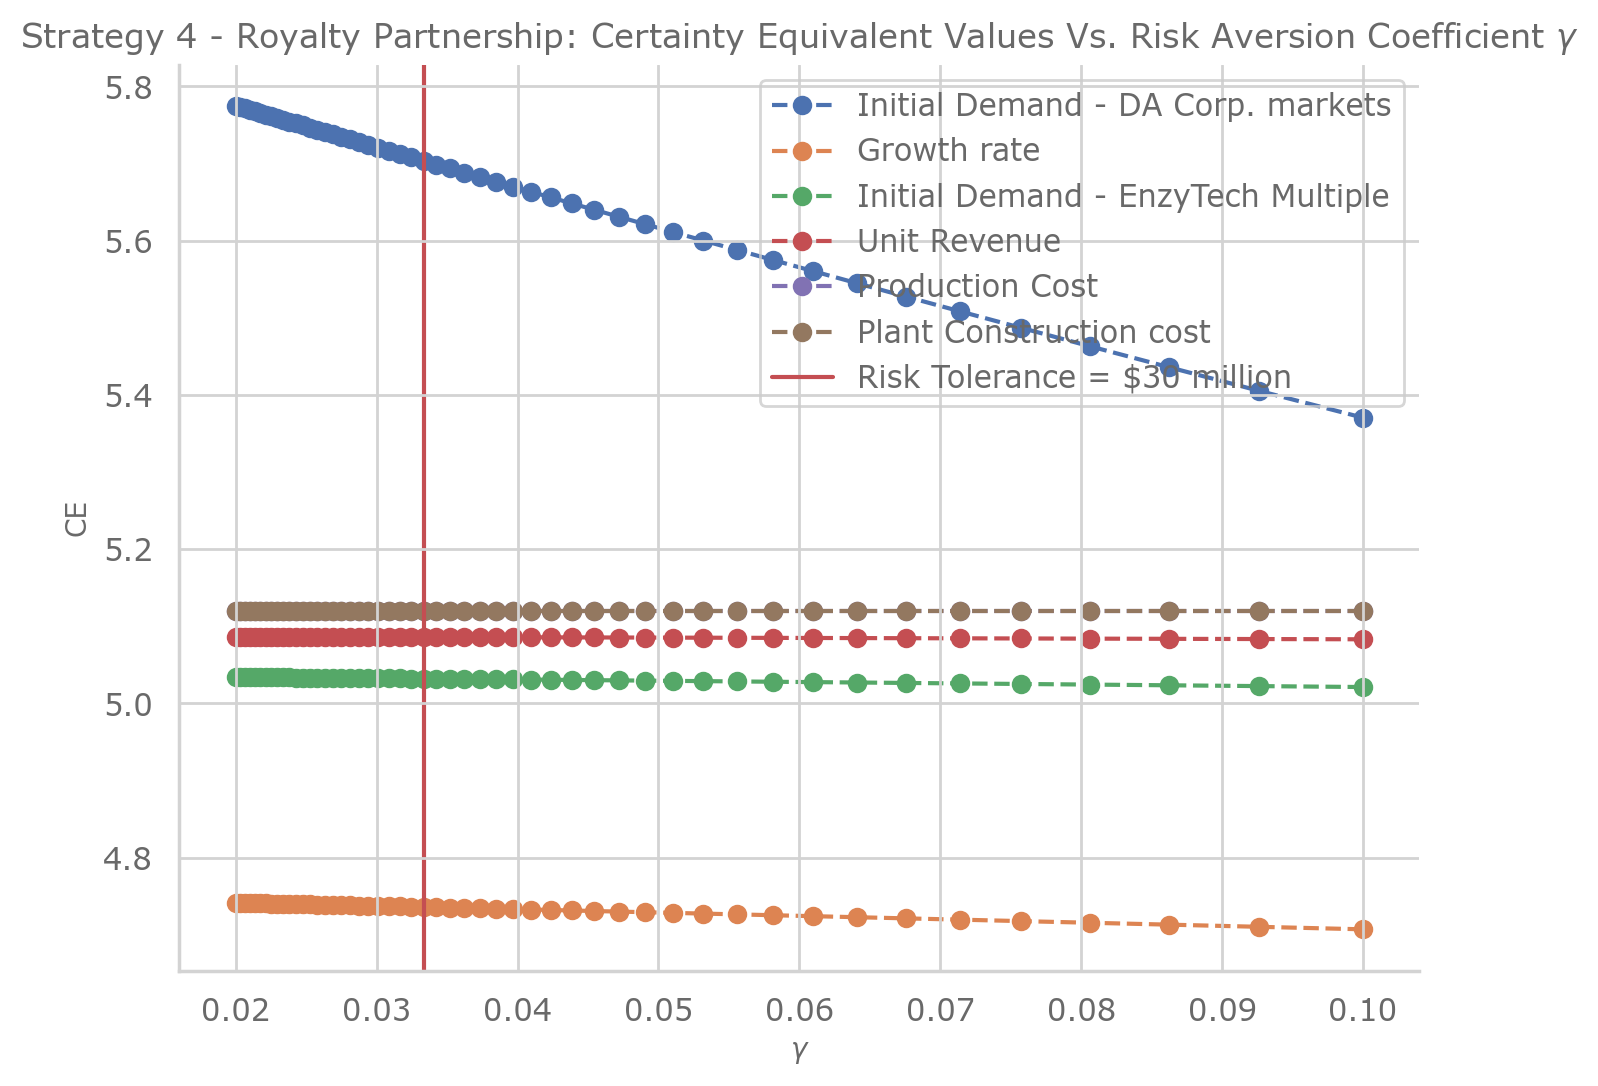

time: 480 ms


<IPython.core.display.Javascript object>

In [126]:
certainty_equivalent_sensitivity_to_risk_tolerance_analysis(
    strategy4_npv,
    name=r"Strategy 4 - Royalty Partnership: Certainty Equivalent Values Vs. Risk Aversion Coefficient $\gamma$",
)

---
## 3) Value of Free Clairvoyance

In [142]:
def value_of_clairvoyance(u, u_inv, x, p):
    """Calculates the Value of Clairvoyance
    = Value of Free Clairvoyance - Value of No Clairvoyance
    AKA How much more value we get when we have access
    to an oracle that can tell us the actual outcome of a
    random event.

    Args:
        u (function): U-curve function
        u_inv (function): Inverse U-curve function
        x (np.array): Payoffs of prospects matrix, Shape = (Number of deals, Number of prospects in each deal)
        p (np.array): Probabilities of each prospect matrix, Shape = (Number of deals, Number of prospects in each deal)

    Returns:
        float:
            Value of the Clairvoyance
    """

    # Check that payoffs and probability assignments are the same shape
    assert (
        x.shape == p.shape
    ), "Payoffs `x` and Probabilities `p` must be the same shape=(Number of deals, Number of prospects in each deal)."

    # Value of Free Clairvoyance
    vfc = certainty_equivalent_values_calculator(
        u=u,
        u_inv=u_inv,
        x=np.array([x.max(axis=0)]),
        p=np.array([p[np.argmax(x, axis=0), np.array(range(x.shape[1]))]]),
        γ=np.array([u.keywords["γ"]]),
    )[0][0]

    # Value of No Clairvoyance
    vnc = np.max(
        certainty_equivalent_values_calculator(
            u=u,
            u_inv=u_inv,
            x=x,
            p=p,
            γ=np.array([u.keywords["γ"]]),
        )
    )

    # Value of Clairvoyance
    return np.round(vfc - vnc, 2)

time: 621 µs


<IPython.core.display.Javascript object>

In [156]:
for uncertainty_idx in range(6):
    strategies = pd.concat(
        [
            strategy1_npv.iloc[uncertainty_idx],
            strategy2_npv.iloc[uncertainty_idx],
            strategy3_npv.iloc[uncertainty_idx],
            strategy4_npv.iloc[uncertainty_idx],
        ],
        axis=1,
    )
    strategies.columns = [f"Strategy {idx+1}" for idx in range(4)]

    print(
        strategy1_npv.iloc[uncertainty_idx].name,
        ":",
        value_of_clairvoyance(
            u=partial(u, γ=1 / 30),
            u_inv=partial(u_inv, γ=1 / 30),
            x=strategies.T.values,
            p=np.array([[0.25, 0.5, 0.25]] * 4),
        ),
    )

Initial Demand - DA Corp. markets : 2.74
Growth rate : 0.0
Initial Demand - EnzyTech Multiple : 0.0
Unit Revenue : 0.62
Production Cost : 0.0
Plant Construction cost : 0.0
time: 16.2 ms


<IPython.core.display.Javascript object>